In [1]:
import numpy as np
import qiskit
from qiskit import Aer
backend = Aer.get_backend("statevector_simulator")
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

The toy problem explores a 2-qubit system:
$$\big|\psi\rangle=\alpha\big|00\rangle+\beta\big|01\rangle+\gamma\big|10\rangle+\delta\big|11\rangle$$
where the amplitude for each state is a complex number while $\left|\alpha\right|^{2} = \left|\beta\right|^{2} + \left|\gamma\right|^{2} + \left|\delta\right|^{2} = 1$.

The quantum gates are unitary operation. We can pick some gates that are in SU(2), namely, Ry and Rz rotational gate.

$$R_y(\theta) = \left[\begin{array}{cc}
\cos \frac{\theta}{2} & -\sin \frac{\theta}{2} \\
\sin \frac{\theta}{2} & \cos \frac{\theta}{2}
\end{array}\right]$$
$$R_z(\theta) = \left[\begin{array}{cc}
e^{-i \theta / 2} & 0 \\
0 & e^{i \theta / 2}
\end{array}\right]$$

Since the qubit can also be represented on a Bloch sphere and ZYZ can specify any rotation, the qubit seems to be a homogeneous vector space for SU(2). As a result, we want to construct a NN that is equivariant to SU(2).

To construct a problem for NN to solve, we can choose regression or classification.

Regression: Input = The final statevector* (the 4 complex amplitudes); Output = The angle for each rotation

Classification: WIP. Classify between entangled and not entangled states?

*Note that the statevector is not measurable in the real world. We can only measure the qubit in a certain basis ($\langle \psi \big| \sigma_z  \big| \psi \rangle$) 

In [2]:
def parametric_qc(l):
    # a parametric circuits with ZYZ gates and no entanglement
    qc = qiskit.QuantumCircuit(2,2)
    qc.rz(l[0], 0)
    qc.rz(l[1], 1)
    qc.ry(l[2], 0)
    qc.ry(l[3], 1)
    qc.rz(l[4], 0)
    qc.rz(l[5], 1)
    return qc

In [3]:
qc = parametric_qc([np.pi/8]*6)
qc.draw()

┌──────────┐┌──────────┐┌──────────┐
q_0: ┤ RZ(pi/8) ├┤ RY(pi/8) ├┤ RZ(pi/8) ├
     ├──────────┤├──────────┤├──────────┤
q_1: ┤ RZ(pi/8) ├┤ RY(pi/8) ├┤ RZ(pi/8) ├
     └──────────┘└──────────┘└──────────┘
c: 2/════════════════════════════════════

In [4]:
result = qiskit.execute(qc, backend).result()
psi = result.get_statevector(qc)

In [5]:
print(psi)
print(psi[0]*psi[3] - psi[1]*psi[2])

[0.96193977+0.j         0.1767767 +0.0732233j  0.1767767 +0.0732233j
 0.02691265+0.02691265j]
(3.469446951953614e-18+3.469446951953614e-18j)


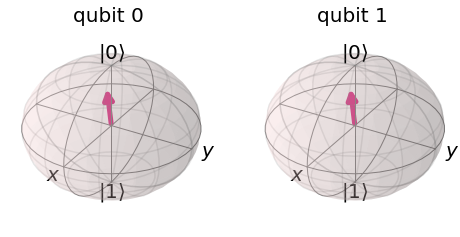

In [6]:
plot_bloch_multivector(psi)

In [7]:
def parametric_qc_entanglement(l):
    # a parametric circuits with ZYZ gates and entanglement
    qc = qiskit.QuantumCircuit(2,2)
    qc.rz(l[0], 0)
    qc.rz(l[1], 1)
    qc.ry(l[2], 0)
    qc.ry(l[3], 1)
    qc.cx(0,1)
    qc.rz(l[4], 0)
    qc.rz(l[5], 1)
    return qc

In [8]:
qc = parametric_qc_entanglement([np.pi/8]*6)
qc.draw()

┌──────────┐┌──────────┐     ┌──────────┐
q_0: ┤ RZ(pi/8) ├┤ RY(pi/8) ├──■──┤ RZ(pi/8) ├
     ├──────────┤├──────────┤┌─┴─┐├──────────┤
q_1: ┤ RZ(pi/8) ├┤ RY(pi/8) ├┤ X ├┤ RZ(pi/8) ├
     └──────────┘└──────────┘└───┘└──────────┘
c: 2/═════════════════════════════════════════

In [9]:
result = qiskit.execute(qc, backend).result()
psi = result.get_statevector(qc)

In [10]:
print(psi)
print(psi[0]*psi[3] - psi[1]*psi[2])

[0.96193977+0.j         0.03516307+0.01456502j 0.1767767 +0.0732233j
 0.13529903+0.13529903j]
(0.12499999999999999+0.12499999999999999j)


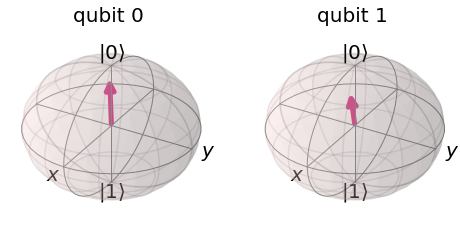

In [11]:
plot_bloch_multivector(psi)

## Generate Data for Regression
We choose x * N angles randomly which are used in the circuit with x rotation gates. So we have N data points. We want our model to output the value of the angle when given the statevector (psi).

In [18]:
N = 100000
x = 6
angles = np.random.uniform(0, 2*np.pi, size=x*N).reshape(N,x)
print(angles.shape)

(100000, 6)


In [19]:
#qcs = np.apply_along_axis(parametric_qc, 1, angles)
qcs = []
for i in range(N):
    qcs.append(parametric_qc(angles[i]))

In [20]:
result = qiskit.execute(qcs, backend)

In [21]:
results = np.array((result.result().results))

In [22]:
print(results.shape)

(100000,)


In [23]:
print(results[10].data.to_dict())

{'counts': {'0x0': 1}, 'statevector': array([ 0.79156902+0.j        , -0.27298116+0.13164631j,
       -0.36297663+0.33737093j,  0.06906807-0.17671288j])}


In [24]:
def get_statevector(result):
    result = result.data.to_dict()
    psi = result["statevector"]
    return psi

In [25]:
# X = get_statevector(results)

In [26]:
X = []
for i in range(N):
     X.append(results[i].data.to_dict()["statevector"])
print(len(X))

100000


In [27]:
X = np.array(X)
print(X.shape)

(100000, 4)


In [28]:
Y = angles
print(Y.shape)

(100000, 6)


In [30]:
h = h5py.File("WIP_toy_qubit_regression.hdf5","w")
h.create_dataset('statevector', data=X)
h.create_dataset('angles', data=Y)
h.close()